In [1]:
import pandas as pd
import numpy as np
from dateutil import parser
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

In [2]:
!gdown "https://drive.google.com/uc?id=1qB32WBARlZe3VIVEPi0Ontgry-_AyBJe"
!gdown "https://drive.google.com/uc?id=1KTDgNMLQaIV2529h4xOcRqMGURFnoVQs"

Downloading...
From: https://drive.google.com/uc?id=1qB32WBARlZe3VIVEPi0Ontgry-_AyBJe
To: /content/train.csv
100% 31.3M/31.3M [00:00<00:00, 132MB/s]
Downloading...
From: https://drive.google.com/uc?id=1KTDgNMLQaIV2529h4xOcRqMGURFnoVQs
To: /content/test.csv
100% 79.6k/79.6k [00:00<00:00, 50.5MB/s]


In [3]:
train_pd = pd.read_csv('train.csv', parse_dates=["time"])
test_pd = pd.read_csv('test.csv', parse_dates=["time"])

In [4]:
train_pd.dropna(inplace = True)
test_pd.dropna(inplace = True)

In [ ]:
train_pd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 848835 entries, 0 to 848834
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   row_id      848835 non-null  int64         
 1   time        848835 non-null  datetime64[ns]
 2   x           848835 non-null  int64         
 3   y           848835 non-null  int64         
 4   direction   848835 non-null  object        
 5   congestion  848835 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 45.3+ MB


In [ ]:
train_pd.describe()

,row_id,x,y,congestion
count,848835.00000,848835.000000,848835.000000,848835.000000
mean,424417.00000,1.138462,1.630769,47.815305
std,245037.70221,0.801478,1.089379,16.799392
min,0.00000,0.000000,0.000000,0.000000
25%,212208.50000,0.000000,1.000000,35.000000
50%,424417.00000,1.000000,2.000000,47.000000
75%,636625.50000,2.000000,3.000000,60.000000
max,848834.00000,2.000000,3.000000,100.000000


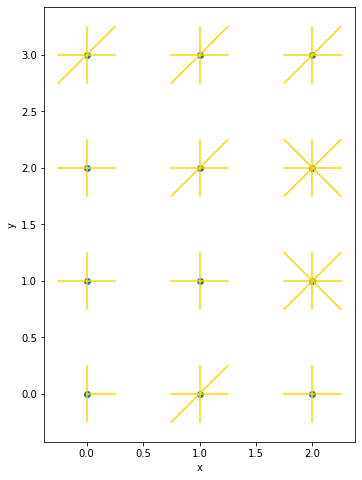

In [6]:
# Unique roadways
roadways = train_pd[['x', 'y']].drop_duplicates()

# Unique roadways with direction
road_dir = train_pd[['x', 'y', 'direction']].drop_duplicates()

dir_dict = {'EB': (1, 0), 'NB': (0, 1), 'SB': (0, -1), 'WB': (-1, 0), 'NE': (1, 1), 'SE': (1, -1), 'NW': (-1, 1), 'SW': (-1, -1)}

plt.figure(figsize=(8, 8))
plt.scatter(roadways.x, roadways.y)
plt.gca().set_aspect('equal')
for _, x, y, d in road_dir.itertuples():
    dx, dy = dir_dict[d]
    dx, dy = dx/4, dy/4
    plt.plot([x, x+dx], [y, y+dy], color='#ffd700')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

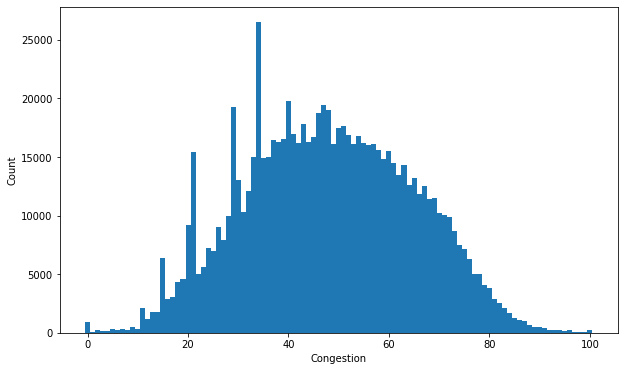

In [13]:
plt.figure(figsize=(10, 6))

plt.bar(range(101), train_pd.congestion.value_counts().sort_index(), width=1,)
plt.ylabel('Count')
plt.xlabel('Congestion')
plt.show()

In [5]:
test_pd['day'] = test_pd['time'].dt.dayofweek
# test_pd['date'] = test_pd['time'].dt.date
# test_pd['day_month'] = test_pd['time'].dt.strftime('%d').astype('int')
test_pd['weekend'] = (test_pd['day'] > 4).astype('uint8')
test_pd['hour'] = test_pd['time'].dt.hour
test_pd['hour_part'] = test_pd['time'].dt.minute
test_pd['hour_part'] = test_pd['hour_part'].map({0:0, 20: 1, 40: 2})
# test_pd['month'] = test_pd['time'].dt.month

train_pd['day'] = train_pd['time'].dt.dayofweek
# train_pd['date'] = train_pd['time'].dt.date
# train_pd['day_month'] = train_pd['time'].dt.strftime('%d').astype('int')
train_pd['weekend'] = (train_pd['day'] > 4).astype('uint8')
train_pd['hour'] = train_pd['time'].dt.hour
train_pd['hour_part'] = train_pd['time'].dt.minute
train_pd['hour_part'] = train_pd['hour_part'].map({0:0, 20: 1, 40: 2})
# train_pd['month'] = train_pd['time'].dt.month


In [ ]:
train_pd

,row_id,time,x,y,direction,congestion,day,weekend,hour,hour_part
0,0,1991-04-01 00:00:00,0,0,EB,70,0,0,0,0
1,1,1991-04-01 00:00:00,0,0,NB,49,0,0,0,0
2,2,1991-04-01 00:00:00,0,0,SB,24,0,0,0,0
3,3,1991-04-01 00:00:00,0,1,EB,18,0,0,0,0
4,4,1991-04-01 00:00:00,0,1,NB,60,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
848830,848830,1991-09-30 11:40:00,2,3,NB,54,0,0,11,2
848831,848831,1991-09-30 11:40:00,2,3,NE,28,0,0,11,2
848832,848832,1991-09-30 11:40:00,2,3,SB,68,0,0,11,2
848833,848833,1991-09-30 11:40:00,2,3,SW,17,0,0,11,2


In [ ]:
test_pd

,row_id,time,x,y,direction,day,weekend,hour,hour_part
0,848835,1991-09-30 12:00:00,0,0,EB,0,0,12,0
1,848836,1991-09-30 12:00:00,0,0,NB,0,0,12,0
2,848837,1991-09-30 12:00:00,0,0,SB,0,0,12,0
3,848838,1991-09-30 12:00:00,0,1,EB,0,0,12,0
4,848839,1991-09-30 12:00:00,0,1,NB,0,0,12,0
...,...,...,...,...,...,...,...,...,...
2335,851170,1991-09-30 23:40:00,2,3,NB,0,0,23,2
2336,851171,1991-09-30 23:40:00,2,3,NE,0,0,23,2
2337,851172,1991-09-30 23:40:00,2,3,SB,0,0,23,2
2338,851173,1991-09-30 23:40:00,2,3,SW,0,0,23,2


In [ ]:
df = train_pd['congestion'].groupby(train_pd['date']).mean()

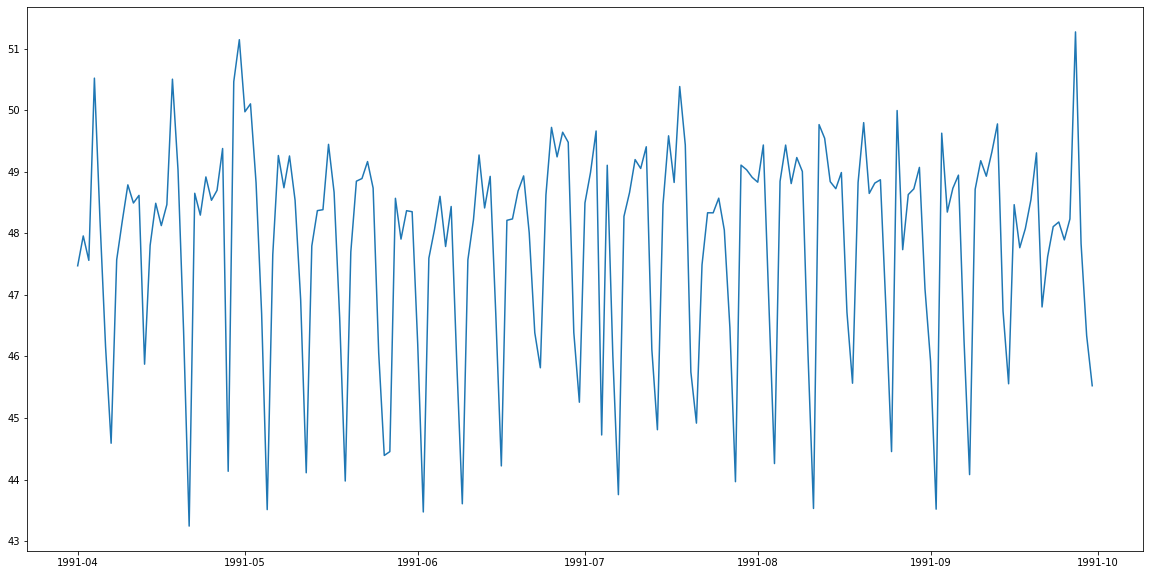

In [ ]:
plt.figure(figsize=(20,10)) 
plt.plot(df.index, df.values)
# plt.xticks(df.index)
plt.show()


In [ ]:
df1 = train_pd['congestion'].groupby(train_pd['day']).mean()

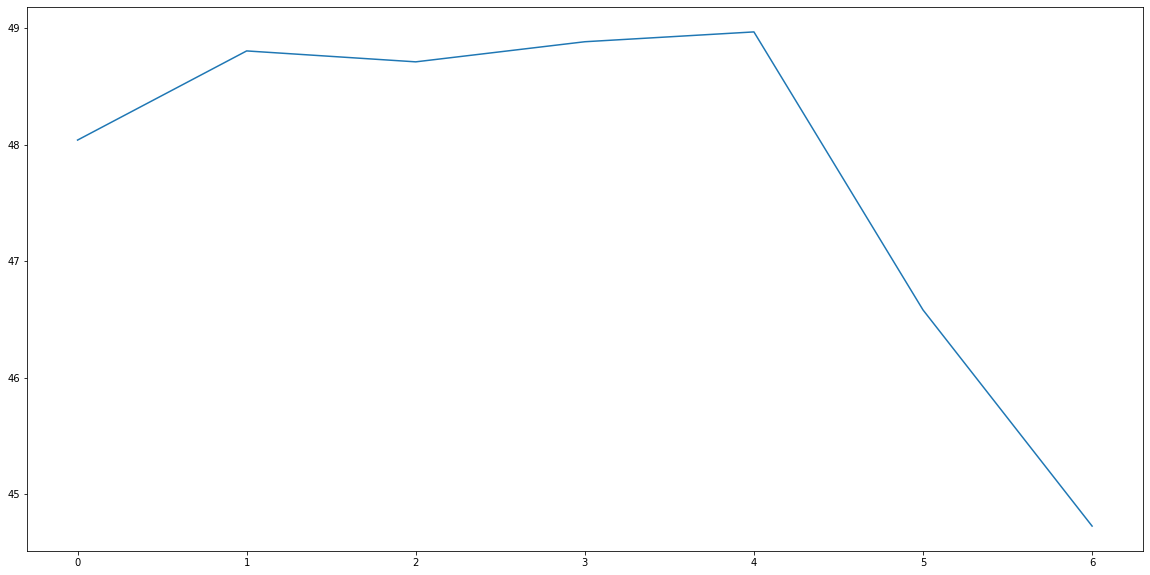

In [ ]:
plt.figure(figsize=(20,10)) 
plt.plot(df1.index, df1.values)
# plt.xticks(df.index)
plt.show()


In [ ]:
df2 = train_pd['congestion'].groupby(train_pd['hour']).mean()

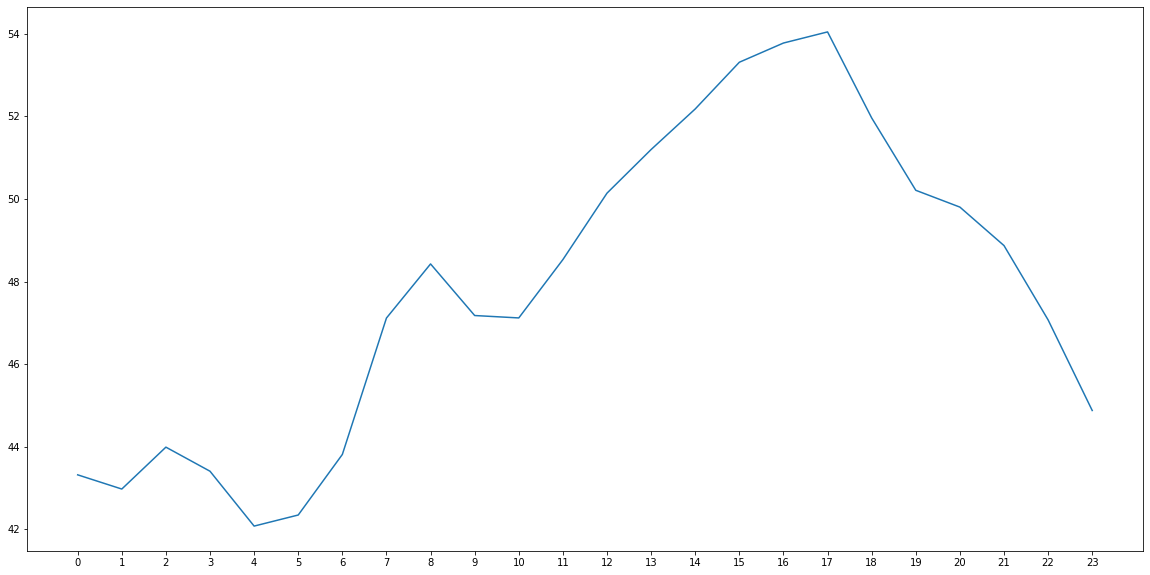

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(df2.index, df2.values)
plt.xticks(df2.index)
plt.show()


In [ ]:
df4 = train_pd[train_pd['weekend']==1]['congestion'].groupby(train_pd['hour']).mean()

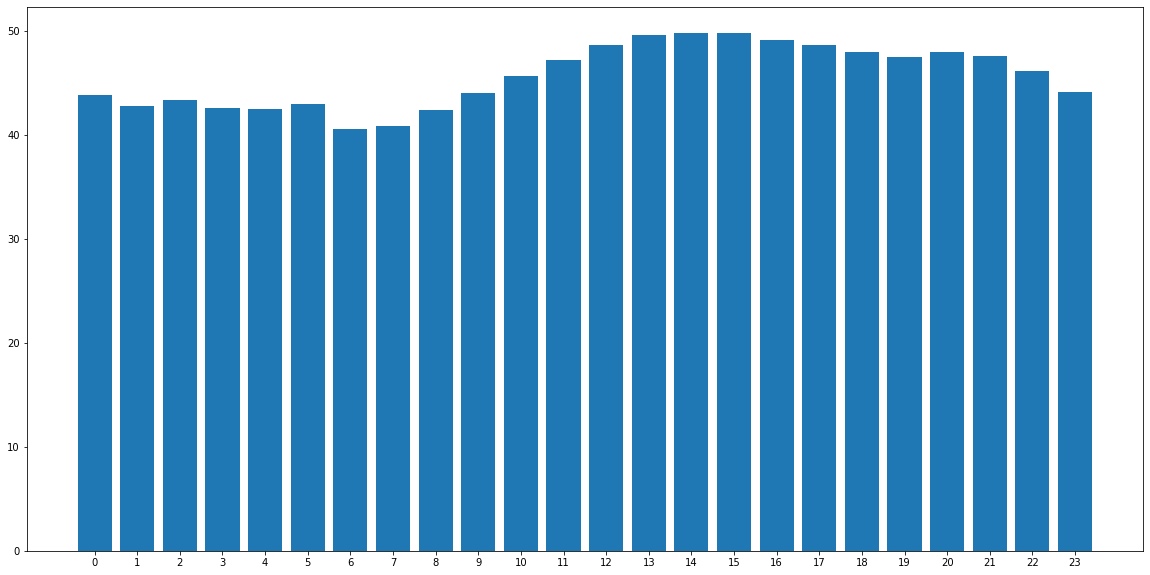

In [ ]:
plt.figure(figsize=(20,10)) 
plt.bar(df4.index, df4.values)
plt.xticks(df4.index)
plt.show()

In [ ]:
df5 = train_pd['congestion'].groupby(train_pd['month']).mean()

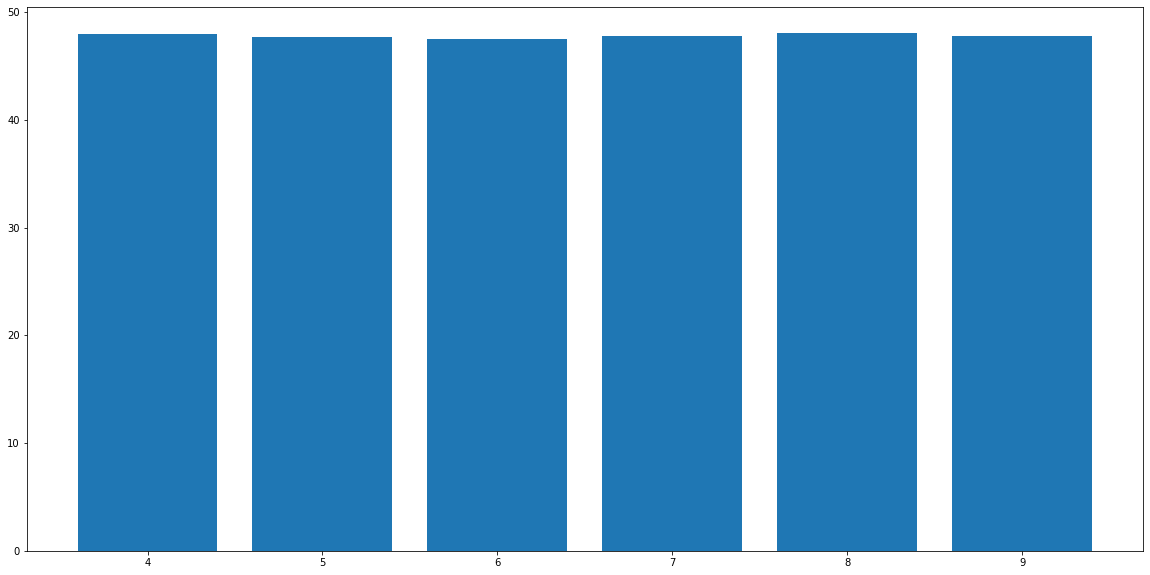

In [ ]:
plt.figure(figsize=(20,10))
plt.bar(df5.index, df5.values)
plt.xticks(df5.index)
plt.show()

In [ ]:
df6 = train_pd['congestion'].groupby(train_pd['direction']).mean()

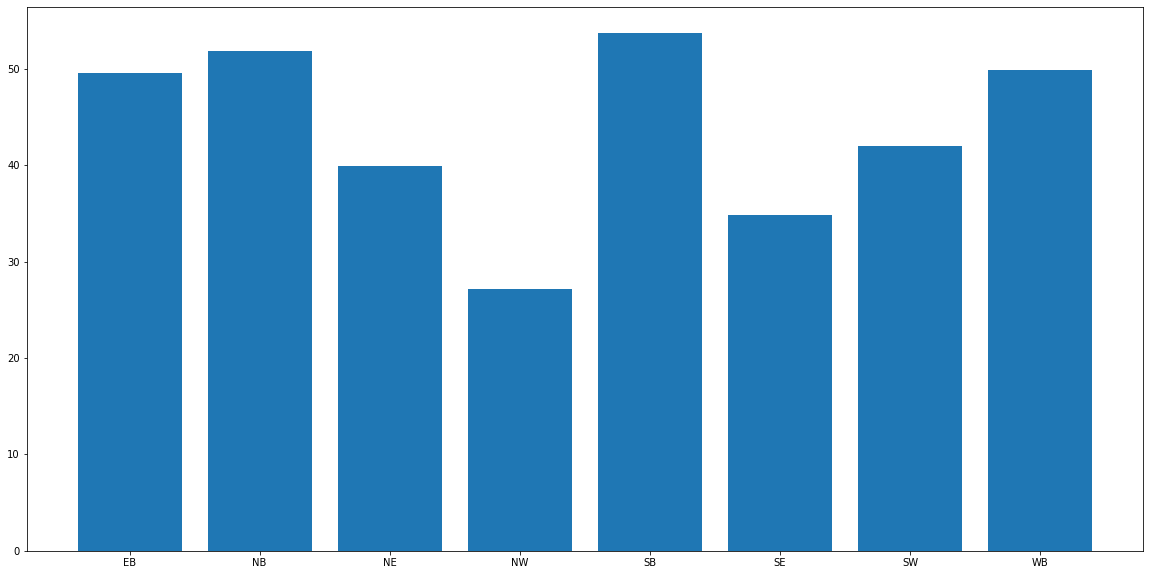

In [ ]:
plt.figure(figsize=(20,10))
plt.bar(df6.index, df6.values)
plt.xticks(df6.index)
plt.show()

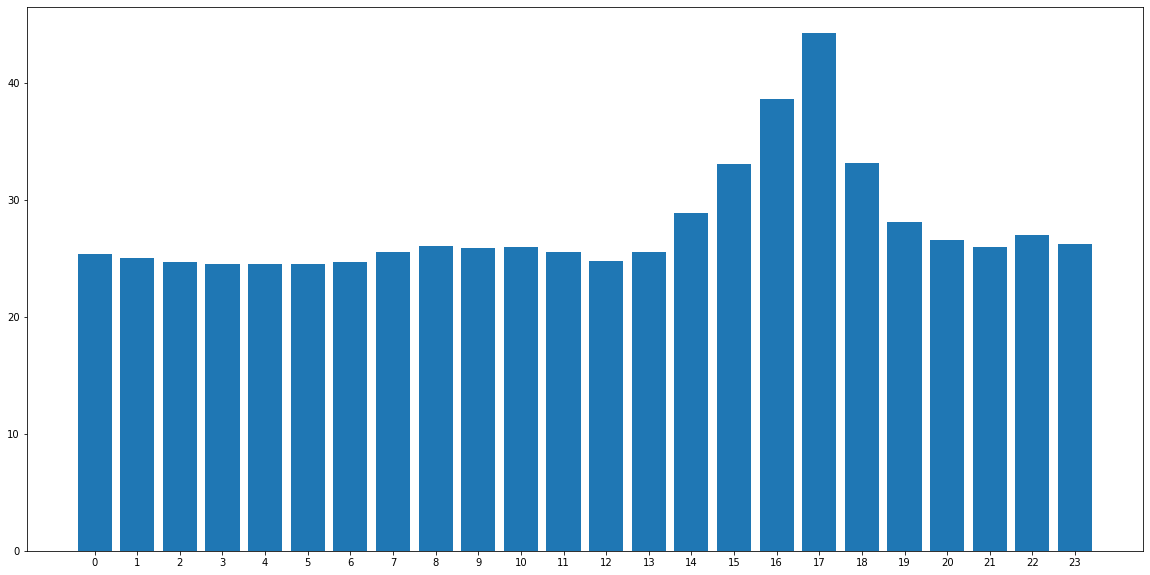

In [ ]:
df7 = train_pd[(train_pd['direction']=='NW') & (train_pd['weekend']==0)]['congestion'].groupby(train_pd['hour']).mean()
plt.figure(figsize=(20,10))
plt.bar(df7.index, df7.values)
plt.xticks(df7.index)
plt.show()

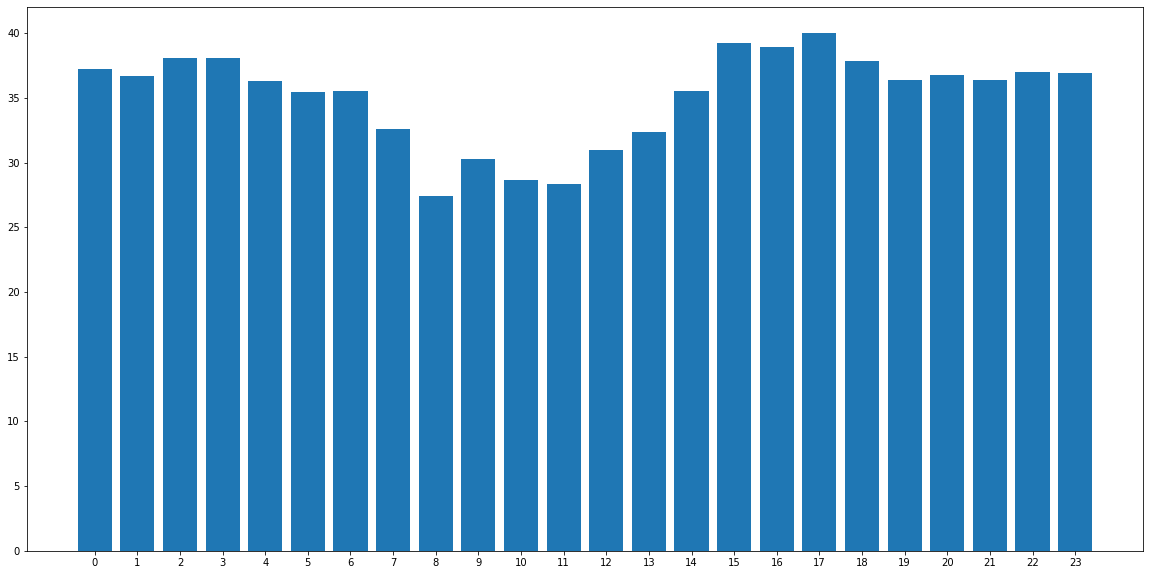

In [ ]:
df8 = train_pd[(train_pd['direction']=='SE') & (train_pd['weekend']==0)]['congestion'].groupby(train_pd['hour']).mean()
plt.figure(figsize=(20,10))
plt.bar(df8.index, df8.values)
plt.xticks(df8.index)
plt.show()

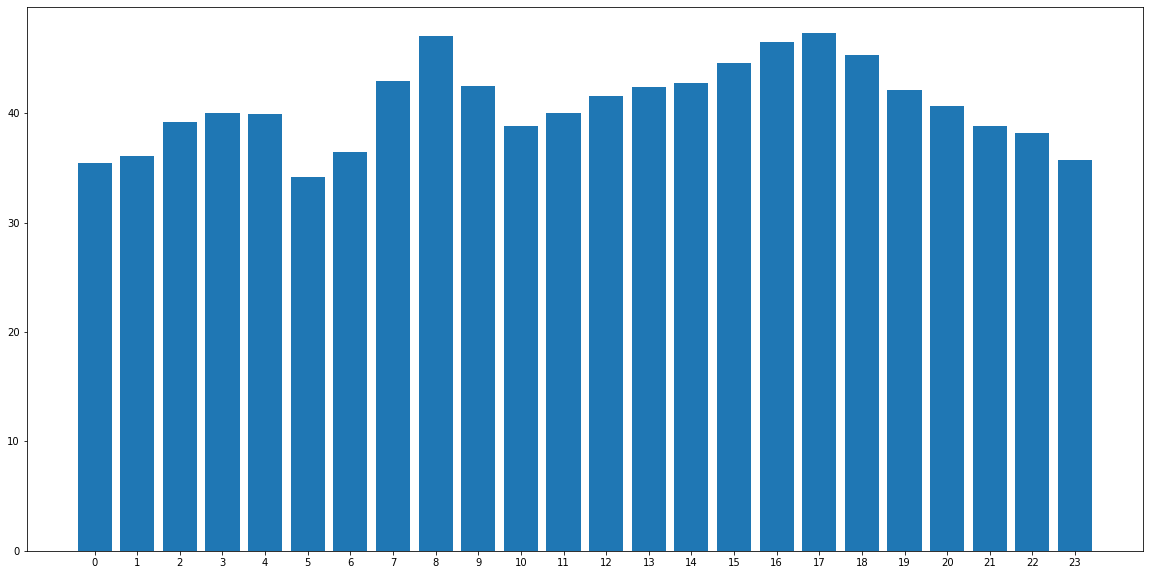

In [ ]:
df9 = train_pd[(train_pd['direction']=='NE') & (train_pd['weekend']==0)]['congestion'].groupby(train_pd['hour']).mean()
plt.figure(figsize=(20,10))
plt.bar(df9.index, df9.values)
plt.xticks(df9.index)
plt.show()

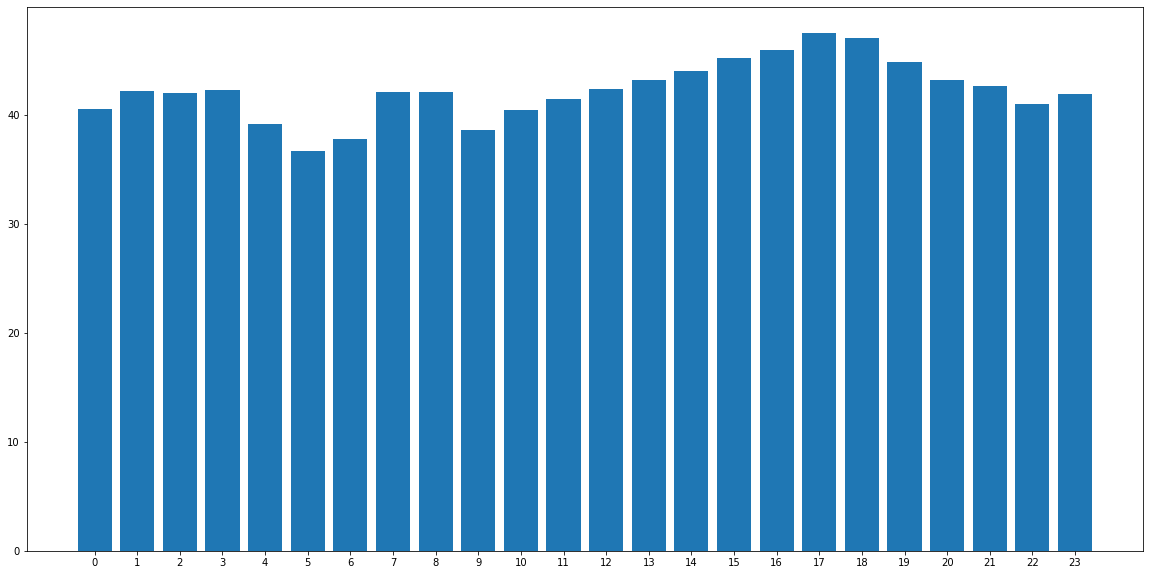

In [ ]:
df10 = train_pd[(train_pd['direction']=='SW') & (train_pd['weekend']==0)]['congestion'].groupby(train_pd['hour']).mean()
plt.figure(figsize=(20,10))
plt.bar(df10.index, df10.values)
plt.xticks(df10.index)
plt.show()

In [6]:
dircn = pd.get_dummies(train_pd['direction'], prefix='direction')
x = pd.get_dummies(train_pd['x'], prefix='x')
y = pd.get_dummies(train_pd['y'], prefix='y')
# month = pd.get_dummies(train_pd['month'], prefix='month')
hour_part = pd.get_dummies(train_pd['hour_part'], prefix='hour_part')
day = pd.get_dummies(train_pd['day'], prefix='day')
# day_month = pd.get_dummies(train_pd['day_month'], prefix='day_month')
hour = pd.get_dummies(train_pd['hour'], prefix='hour')

train_pd = train_pd.drop(['direction'], axis=1)
train_pd = train_pd.drop(['x'], axis=1)
train_pd = train_pd.drop(['y'], axis=1)
# train_pd = train_pd.drop(['month'], axis=1)
train_pd = train_pd.drop(['hour_part'], axis=1)
train_pd = train_pd.drop(['day'], axis=1)
# train_pd = train_pd.drop(['day_month'], axis=1)
train_pd = train_pd.drop(['hour'], axis=1)

train_pd = pd.concat([train_pd, dircn], axis=1)
train_pd = pd.concat([train_pd, x], axis=1)
train_pd = pd.concat([train_pd, y], axis=1)
# train_pd = pd.concat([train_pd, month], axis=1)
train_pd = pd.concat([train_pd, hour_part], axis=1)
train_pd = pd.concat([train_pd, day], axis=1)
# train_pd = pd.concat([train_pd, day_month], axis=1)
train_pd = pd.concat([train_pd, hour], axis=1)

In [7]:
dircn = pd.get_dummies(test_pd['direction'], prefix='direction')
x = pd.get_dummies(test_pd['x'], prefix='x')
y = pd.get_dummies(test_pd['y'], prefix='y')
# month = pd.get_dummies(test_pd['month'], prefix='month')
hour_part = pd.get_dummies(test_pd['hour_part'], prefix='hour_part')
day = pd.get_dummies(test_pd['day'], prefix='day')
# day_month = pd.get_dummies(test_pd['day_month'], prefix='day_month')
hour = pd.get_dummies(test_pd['hour'], prefix='hour')

test_pd = test_pd.drop(['direction'], axis=1)
test_pd = test_pd.drop(['x'], axis=1)
test_pd = test_pd.drop(['y'], axis=1)
# test_pd = test_pd.drop(['month'], axis=1)
test_pd = test_pd.drop(['hour_part'], axis=1)
test_pd = test_pd.drop(['day'], axis=1)
# test_pd = test_pd.drop(['day_month'], axis=1)
test_pd = test_pd.drop(['hour'], axis=1)

test_pd = pd.concat([test_pd, dircn], axis=1)
test_pd = pd.concat([test_pd, x], axis=1)
test_pd = pd.concat([test_pd, y], axis=1)
# test_pd = pd.concat([test_pd, month], axis=1)
test_pd = pd.concat([test_pd, hour_part], axis=1)
test_pd = pd.concat([test_pd, day], axis=1)
# test_pd = pd.concat([test_pd, day_month], axis=1)
test_pd = pd.concat([test_pd, hour], axis=1)
# months = ['month_4', 'month_5', 'month_6', 'month_7', 'month_8']
# for month in reversed(months):
#   test_pd.insert(19, month, 0)

days = ['day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6']

# days_month = ['day_month_1', 'day_month_2', 'day_month_3', 'day_month_4',
#               'day_month_5', 'day_month_6', 'day_month_7', 'day_month_8',
#               'day_month_9', 'day_month_10', 'day_month_11', 'day_month_12',
#               'day_month_13', 'day_month_14', 'day_month_15', 'day_month_16',
#               'day_month_17', 'day_month_18', 'day_month_19', 'day_month_20',
#               'day_month_21', 'day_month_22', 'day_month_23', 'day_month_24',
#               'day_month_25', 'day_month_26', 'day_month_27', 'day_month_28',
#               'day_month_29']#, 'day_month_31']

hours = ['hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6',
         'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11']

for d in reversed(days):
  test_pd.insert(22, d, 0)
# test_pd.insert(36, 'day_month_31', 0)
# for dm in reversed(days_month):
#   test_pd.insert(35, dm, 0)
for h in reversed(hours):
  test_pd.insert(28, h, 0)

In [ ]:
test_pd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2340 entries, 0 to 2339
Data columns (total 52 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   row_id        2340 non-null   int64         
 1   time          2340 non-null   datetime64[ns]
 2   weekend       2340 non-null   uint8         
 3   direction_EB  2340 non-null   uint8         
 4   direction_NB  2340 non-null   uint8         
 5   direction_NE  2340 non-null   uint8         
 6   direction_NW  2340 non-null   uint8         
 7   direction_SB  2340 non-null   uint8         
 8   direction_SE  2340 non-null   uint8         
 9   direction_SW  2340 non-null   uint8         
 10  direction_WB  2340 non-null   uint8         
 11  x_0           2340 non-null   uint8         
 12  x_1           2340 non-null   uint8         
 13  x_2           2340 non-null   uint8         
 14  y_0           2340 non-null   uint8         
 15  y_1           2340 non-null   uint8   

In [ ]:
train_pd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 848835 entries, 0 to 848834
Data columns (total 53 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   row_id        848835 non-null  int64         
 1   time          848835 non-null  datetime64[ns]
 2   congestion    848835 non-null  int64         
 3   weekend       848835 non-null  uint8         
 4   direction_EB  848835 non-null  uint8         
 5   direction_NB  848835 non-null  uint8         
 6   direction_NE  848835 non-null  uint8         
 7   direction_NW  848835 non-null  uint8         
 8   direction_SB  848835 non-null  uint8         
 9   direction_SE  848835 non-null  uint8         
 10  direction_SW  848835 non-null  uint8         
 11  direction_WB  848835 non-null  uint8         
 12  x_0           848835 non-null  uint8         
 13  x_1           848835 non-null  uint8         
 14  x_2           848835 non-null  uint8         
 15  y_0           848

In [8]:
X = train_pd[train_pd.columns.difference(['row_id', 'time', 'congestion'])].copy()
y = train_pd[['congestion']].copy()

X_test = test_pd[test_pd.columns.difference(['row_id', 'time'])].copy()

In [14]:
train_test_split = datetime.strptime('1991-09-23 12:00:00', '%Y-%m-%d %H:%M:%S')

In [ ]:
train_pd[['time','day_0']].iloc[848834-32629:848834-32629+2340,:]

,time,day_0
816205,1991-09-23 12:00:00,1
816206,1991-09-23 12:00:00,1
816207,1991-09-23 12:00:00,1
816208,1991-09-23 12:00:00,1
816209,1991-09-23 12:00:00,1
...,...,...
818540,1991-09-23 23:40:00,1
818541,1991-09-23 23:40:00,1
818542,1991-09-23 23:40:00,1
818543,1991-09-23 23:40:00,1


In [9]:
X_train = X.iloc[:848834-32629,:]
y_train = y.iloc[:848834-32629,:]
X_val = X.iloc[848834-32629:848834-32629+2340,:]
y_val = y.iloc[848834-32629:848834-32629+2340,:]

In [10]:
con_sc = MinMaxScaler()
y_train['congestion'] = con_sc.fit_transform(y_train[['congestion']])
y_val['congestion'] = con_sc.transform(y_val[['congestion']])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## XGBoost for regression

Extreme Gradient Boosting

Gradient boosting refers to a class of ensemble machine learning algorithms that can be used for classification or regression predictive modeling problems.

Ensembles are constructed from decision tree models. Trees are added one at a time to the ensemble and fit to correct the prediction errors made by prior models. This is a type of ensemble machine learning model referred to as boosting.

Models are fit using any arbitrary differentiable loss function and gradient descent optimization algorithm. This gives the technique its name, “gradient boosting,” as the loss gradient is minimized as the model is fit, much like a neural network. [source:  [link text](https://machinelearningmastery.com/xgboost-for-regression/)]

In [11]:
XGB_model = XGBRegressor(n_estimators=50, max_depth=10, eta=0.01, random_state=42, enable_categorical=False)

In [12]:
XGB_model.fit(X_train,y_train.values)

[21:46:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(enable_categorical=False, eta=0.01, max_depth=10, n_estimators=50,
             random_state=42)

In [13]:
from sklearn.metrics import mean_absolute_error
xg_pred = XGB_model.predict(X_val)
mean_absolute_error(y_val.values,xg_pred)

0.05721019664992635

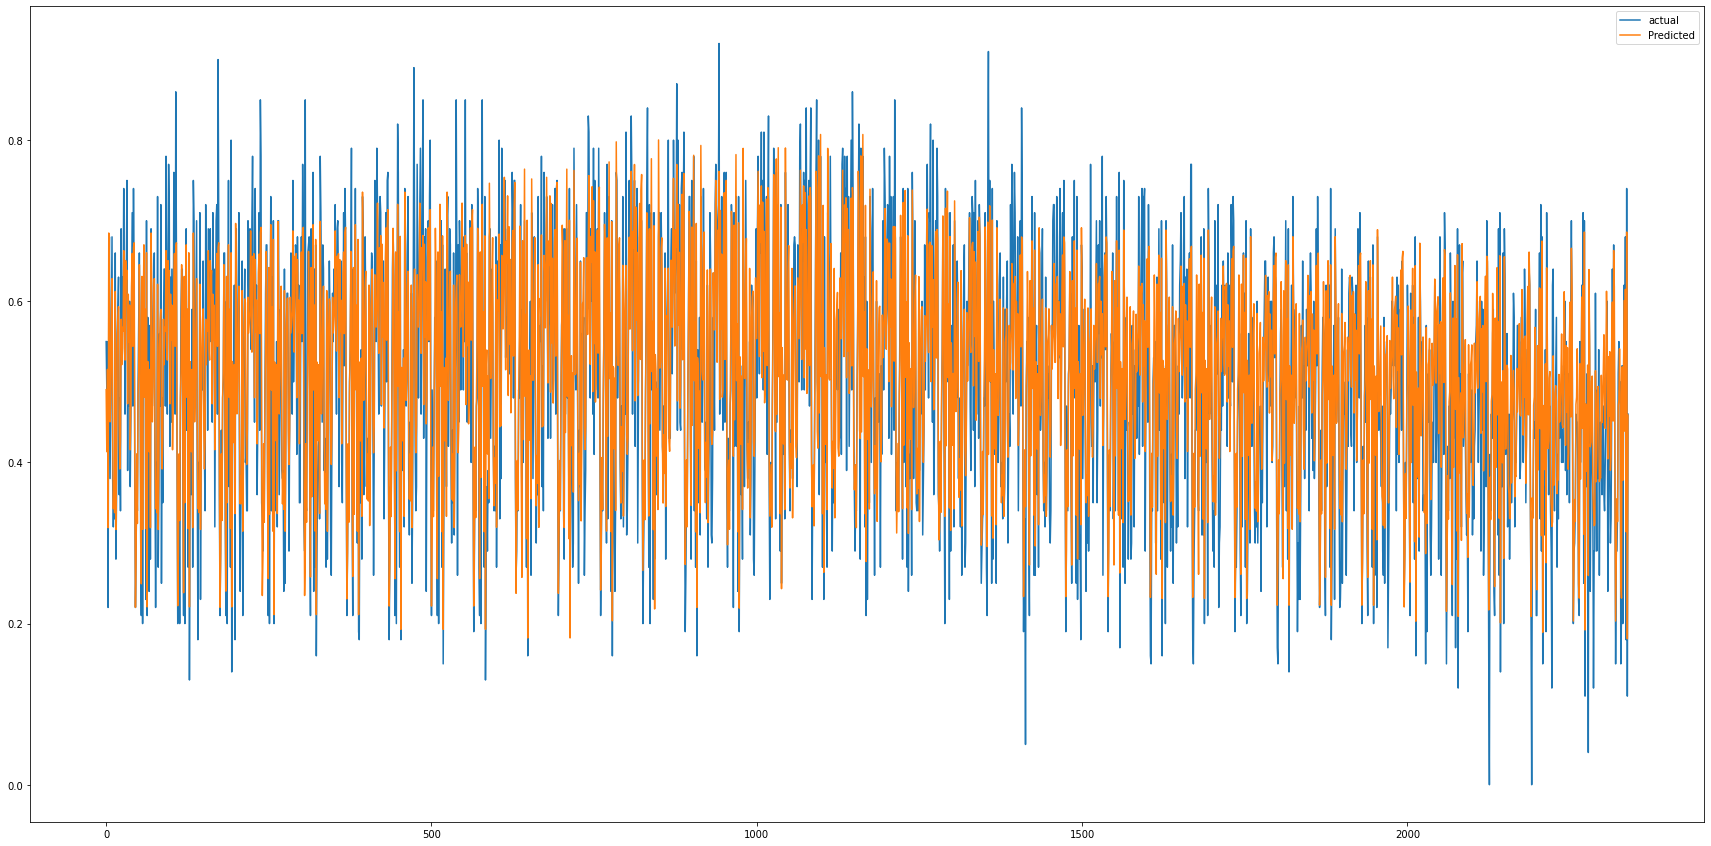

In [21]:
plt.figure(figsize=(30,15))
plt.plot(y_val.values, label='actual')
plt.plot(xg_pred, label='Predicted')
plt.legend()
plt.show()

In [21]:
XGB_model.fit(X,y.values)
pred = XGB_model.predict(X_test)

[21:08:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [23]:
submission = pd.read_csv('submission.csv')

In [26]:
submission['congestion'] = np.round(pred).astype(int)

In [27]:
submission.to_csv('./submission1.csv', index=False)

RandomForrest

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators= 20, max_depth=4, random_state=42, criterion= 'absolute_error')
rf_model.fit(X_train, y_train.values.reshape(y_train.shape[0]))

In [ ]:
from sklearn.metrics import mean_absolute_error
rf_pred = rf_model.predict(X_val)
mean_absolute_error(y_val.values,rf_pred)